In [6]:
import skimage
from skimage import data
from skimage import io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Bilinear Interpolation

In [2]:
imgX = io.imread('Images/GOES-B/GOES-B-True ESRGAN.png')
imgX.shape

(52, 104, 3)

In [3]:
from skimage.transform import resize_local_mean

img = io.imread('Images/GOES-B/GOES-B-True.png')
print("Image Size : ", img.shape)

img_resized = resize_local_mean(img,(53, 104))
Image.fromarray((img_resized* 255).astype(np.uint8)).save("GOES-B BI.jpg")

Image Size :  (13, 26)


## Testing GOES Images

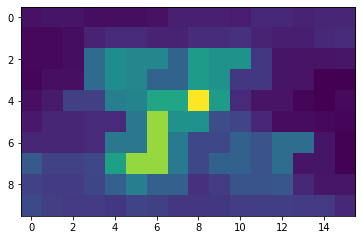

In [3]:
from matplotlib import pyplot as plt
import numpy as np

img_array = np.load('GOES-A/goes_diff_A.npy')

plt.imshow(img_array)
plt.show()

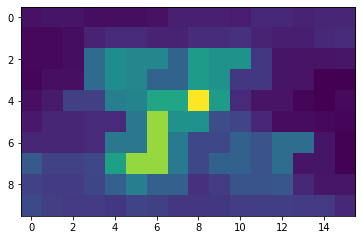

In [6]:
def load_image(array):
    result = np.zeros((array.shape[0], array.shape[1], 3))
    result[:,:,0] = array 
    result[:,:,1] = array 
    result[:,:,2] = array 
    return result

result_image = load_image(img_array)
final = np.mean(result_image, axis=2)

plt.imshow(final)

## Unsharp Mask

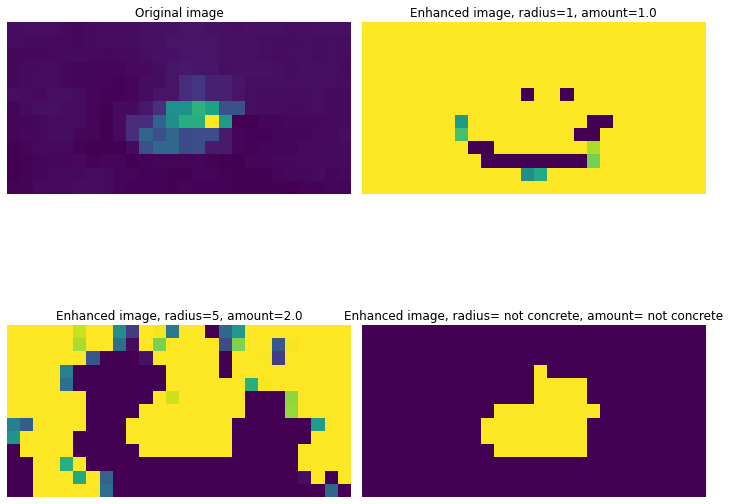

In [83]:
# Unsharp Mask on GOES-B

from skimage.filters import unsharp_mask

img_B = np.load('GOES-B/goes_diff_B.npy') 

result_1 = unsharp_mask(img_B, radius=1, amount=1)
result_2 = unsharp_mask(img_B, radius=5, amount=2)
result_3 = unsharp_mask(img_B, radius=10.5, amount=50)


fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(img_B)
ax[0].set_title('Original image')
ax[1].imshow(result_1)
ax[1].set_title('Enhanced image, radius=1, amount=1.0')
ax[2].imshow(result_2)
ax[2].set_title('Enhanced image, radius=5, amount=2.0')
ax[3].imshow(result_3)
ax[3].set_title('Enhanced image, radius= not concrete, amount= not concrete')

for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()

# This is just taking out all of the granular detail and gradients in the original image, why?

In [8]:
# Unsharp Mask on Tiny Pixel Lady

from skimage.filters import unsharp_mask

img = cv2.imread('TinyPixelWoman/Tiny Pixel Woman.jpg')
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result_1 = unsharp_mask(rgb_img, radius=1, amount=1)
result_2 = unsharp_mask(rgb_img, radius=5, amount=2)
result_3 = unsharp_mask(rgb_img, radius=1, amount=6)


fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(rgb_img)
ax[0].set_title('Original image')
ax[1].imshow(result_1)
ax[1].set_title('Enhanced image, radius=1, amount=1.0')
ax[2].imshow(result_2)
ax[2].set_title('Enhanced image, radius=5, amount=2.0')
ax[3].imshow(result_3)
ax[3].set_title('Enhanced image, radius= not concrete, amount= not concrete')

for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()


[ WARN:0@232.924] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('TinyPixelWoman/Tiny Pixel Woman.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


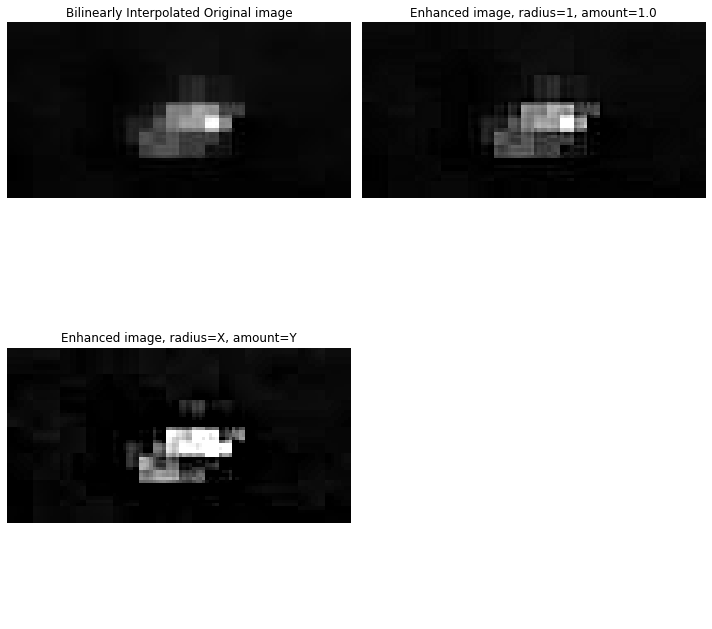

In [48]:
# unsharp mask on grey_scale image of Satellite B

original_B = cv2.imread('Images/GOES-B/GOES-B-True.png')
BI_B = cv2.imread('Images/GOES-B/GOES-B BI.jpg')

#original_B_grey = cv2.cvtColor(original_B, cv2.COLOR_BGR2GRAY)
BI_B_grey = cv2.cvtColor(BI_B, cv2.COLOR_BGR2GRAY)

result_1 = unsharp_mask(BI_B_grey, radius=1, amount=1)
result_2 = unsharp_mask(BI_B, radius=4, amount=2.5)

cv2.imwrite('GOES-B Unsharp Mask.jpg', 255*result_2)

fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(BI_B_grey, cmap = plt.cm.gray)
ax[0].set_title('Bilinearly Interpolated Original image')
ax[1].imshow(result_1, cmap = plt.cm.gray)
ax[1].set_title('Enhanced image, radius=1, amount=1.0')
ax[2].imshow(result_2, cmap = plt.cm.gray)
ax[2].set_title('Enhanced image, radius=X, amount=Y')

for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()


In [10]:
# Trying to optimize Unsharp Mask
from skimage.metrics import structural_similarity as ssim 
from skimage.filters import unsharp_mask

def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def compare_images(imageA, imageB):
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)
    comp_vals = [m,s]
    return comp_vals

In [44]:
# initial algorithm, basically brute force
BI_B = cv2.imread('Images/GOES-B/GOES-B BI.jpg')
BI_B_grey = cv2.cvtColor(BI_B, cv2.COLOR_BGR2GRAY)

upper_bound = 10
m = 0
n = 0

mses = [[0.0]*(upper_bound**5) for i in range(upper_bound**2)]
ssims = [[0.0]*(upper_bound**5) for i in range(upper_bound**2)]

for i in np.arange(0.0, float(upper_bound), 0.5):
    for j in np.arange(0.0, float(upper_bound), 0.5):
        result = unsharp_mask(BI_B_grey, radius=i, amount=j) 
        ret_vals = compare_images(BI_B_grey, result)
        
        print('i: ' + str(i) + ' j: ' + str(j) + ' m: ' + str(ret_vals[0]) + ' s: ' + str(ret_vals[1]))
        
        mses[m][n] = ret_vals[0]
        ssims[m][n] = ret_vals[1]
        n+=1
    m+=1


i: 0.0 j: 0.0 m: 936.2428513874032 s: 0.15918544472189058
i: 0.0 j: 0.5 m: 936.2428513874032 s: 0.15918544472189058
i: 0.0 j: 1.0 m: 936.2428513874032 s: 0.15918544472189058
i: 0.0 j: 1.5 m: 936.2428513874032 s: 0.15918544472189058
i: 0.0 j: 2.0 m: 936.2428513874032 s: 0.15918544472189058
i: 0.0 j: 2.5 m: 936.2428513874032 s: 0.15918544472189058
i: 0.0 j: 3.0 m: 936.2428513874032 s: 0.15918544472189058
i: 0.0 j: 3.5 m: 936.2428513874032 s: 0.15918544472189058
i: 0.0 j: 4.0 m: 936.2428513874032 s: 0.15918544472189058
i: 0.0 j: 4.5 m: 936.2428513874032 s: 0.15918544472189058
i: 0.0 j: 5.0 m: 936.2428513874032 s: 0.15918544472189058
i: 0.0 j: 5.5 m: 936.2428513874032 s: 0.15918544472189058
i: 0.0 j: 6.0 m: 936.2428513874032 s: 0.15918544472189058
i: 0.0 j: 6.5 m: 936.2428513874032 s: 0.15918544472189058
i: 0.0 j: 7.0 m: 936.2428513874032 s: 0.15918544472189058
i: 0.0 j: 7.5 m: 936.2428513874032 s: 0.15918544472189058
i: 0.0 j: 8.0 m: 936.2428513874032 s: 0.15918544472189058
i: 0.0 j: 8.5 

i: 4.0 j: 2.5 m: 933.4557361562705 s: 0.15878015337002785
i: 4.0 j: 3.0 m: 933.159343552494 s: 0.15882086219409028
i: 4.0 j: 3.5 m: 932.904562022573 s: 0.1588808684574856
i: 4.0 j: 4.0 m: 932.680970679258 s: 0.15895514706118766
i: 4.0 j: 4.5 m: 932.4859454044564 s: 0.1590407622651332
i: 4.0 j: 5.0 m: 932.3152570072041 s: 0.15913413308589294
i: 4.0 j: 5.5 m: 932.1635773707592 s: 0.15923345785046503
i: 4.0 j: 6.0 m: 932.0313152495369 s: 0.15933707044535936
i: 4.0 j: 6.5 m: 931.9168445109265 s: 0.15944357503660794
i: 4.0 j: 7.0 m: 931.8135474925443 s: 0.15955410911802545
i: 4.0 j: 7.5 m: 931.7182553307053 s: 0.1596682581961275
i: 4.0 j: 8.0 m: 931.6291856792225 s: 0.15978549266722686
i: 4.0 j: 8.5 m: 931.5522727368626 s: 0.15990549598111475
i: 4.0 j: 9.0 m: 931.4849736957141 s: 0.16002830056406414
i: 4.0 j: 9.5 m: 931.4233311747097 s: 0.16015324734549624
i: 4.5 j: 0.0 m: 936.2428513874032 s: 0.15918544472189058
i: 4.5 j: 0.5 m: 935.4812267079074 s: 0.1588750599634589
i: 4.5 j: 1.0 m: 934.

i: 7.5 j: 5.5 m: 930.9044803831039 s: 0.15863581028050078
i: 7.5 j: 6.0 m: 930.7762109322464 s: 0.15875337576680212
i: 7.5 j: 6.5 m: 930.6756009784746 s: 0.15887448061079995
i: 7.5 j: 7.0 m: 930.5897972511779 s: 0.1589984052032132
i: 7.5 j: 7.5 m: 930.5129967159706 s: 0.15912478949334707
i: 7.5 j: 8.0 m: 930.4414903964569 s: 0.15925306418888602
i: 7.5 j: 8.5 m: 930.3770473105016 s: 0.1593832667550887
i: 7.5 j: 9.0 m: 930.3204871460673 s: 0.1595143929828956
i: 7.5 j: 9.5 m: 930.2695109875987 s: 0.1596467519719369
i: 8.0 j: 0.0 m: 936.2428513874032 s: 0.15918544472189058
i: 8.0 j: 0.5 m: 934.9116517628573 s: 0.15839802527379312
i: 8.0 j: 1.0 m: 933.7110768453733 s: 0.15809832833523452
i: 8.0 j: 1.5 m: 932.9728867159122 s: 0.15798606868235623
i: 8.0 j: 2.0 m: 932.4561064100293 s: 0.15795925166199432
i: 8.0 j: 2.5 m: 932.0981729929373 s: 0.15798653516763872
i: 8.0 j: 3.0 m: 931.7846021525669 s: 0.15804507320476954
i: 8.0 j: 3.5 m: 931.4993752570869 s: 0.15812201505057114
i: 8.0 j: 4.0 m: 9

In [45]:
def find_min_idx(x):
    x = np.array(x)
    k = x.argmin()
    ncol = x.shape[1]
    return k//ncol, k%ncol

def find_max_idx(x):
    x = np.array(x)
    k = x.argmax()
    ncol = x.shape[1]
    return k//ncol, k%ncol

x_min,y_min = find_min_idx(mses)
x_max,y_max = find_max_idx(ssims)

print("radius mses: " + str(x_min))
print("amount mses: " + str(y_min))
print()
print("radius ssim: " + str(x_max))
print("amount ssim: " + str(y_max))


radius mses: 0
amount mses: 20

radius ssim: 4
amount ssim: 99


In [ ]:
# trying to make a better algorithm 
#scrapped cause its a bit of a waste of human time
'''
BI_B = cv2.imread('GOES-B/GOES-B BI.jpg')
BI_B_grey = cv2.cvtColor(BI_B, cv2.COLOR_BGR2GRAY)

upper_bound = 20
mses = [[0]*upper_bound for i in range(upper_bound)]

r = upper_bound//2
a = upper_bound//2

initial_result = unsharp_mask(BI_B_grey, radius=r, amount=a) 
initial_ret_vals = compare_images(BI_B_grey, initial_result)

for k in range(0, 10):
    i = 1
    j = 1
    
    result = unsharp_mask(BI_B_grey, radius=i, amount=j) 
    ret_vals = compare_images(BI_B_grey, result)
    
    if initial_ret_vals[0] < ret_vals[0]:
'''